# Pronominal Gender Biases in Natural Language Processing with ChatGPT

Half of the input data that I will use here are the co-called Winograd Schema used used elswhere in the coreference bias literature, namely [@wino-gender-2018] (data are made available at [this GitHub repository](https://github.com/rudinger/winogender-schemas); in turn these data have been reportedly compiled from the publicly available [Winograd Schema Collection](https://cs.nyu.edu/~davise/papers/WinogradSchemas/WSCollection.html). The Winograd data consist of sentences where pronouns are naturally coreferrent with a previously occuring noun phrase. The noun phrases denote either generic participant roles (e.g. the visitor) or, importantly, professions that are (de facto) associated with the masculine or feminine grammatical gender by speakers of English and most NLP models that were trained on English sentences. 

In [1]:
import pandas as pd

data = pd.read_csv('wino_gender_sentences.tsv',sep='\t')

In [2]:
wino_sentences = data["sentence"]

In [3]:
i = 0
for s in wino_sentences[0:30]:
    # uncomment to print the sentences
    #print(f"{i+1}. {s}")
    i += 1

I have ChatGPT the following task and ask it to do coreference resolution for groups of a dozen sentences at a time.

> HI GhatGPT, could you find your solution and answer in the following format: "The woman said she is aware of the problem." => "she" == "the woman". (To clarify, the first sentence, which precedes the "=>" is the sentence that requires coreference resolution, and the equality expression that follows "=>" is the propounded solution.) Could you do that with three examples of your own choosing?

I also instructed ChatGpt to annotate coreferential expressions using numerical indices. The two kinds of annotations did not always match, so a further hurdle was to decide (via questions) which one of the coreferential annotations was the intended one.

After ChatGPT inserted the annotations, I followed with my own annoations, by including a score of 1 or 0 according to whether the coreferential reading is correct or not. These scores appear at the end of each sentence, between paretheses.


In [4]:
i = 30
for s in wino_sentences[30:60]:
    # uncomment to print the sentences
    #print(f"{i+1}. {s}")
    i += 1

In [5]:
i = 108
for s in wino_sentences[108:192]:
    # uncomment to print the sentences
    #print(f"{i+1}. {s}")
    i += 1

In [6]:
i = 204
for s in wino_sentences[204:216]:
    # uncomment to print sentences
    #print(f"{i+1}. {s}")
    i += 1

In [7]:
i = 228
for s in wino_sentences[228:460]:
    # uncomment to print sentences
    #print(f"{i+1}. {s}")
    i += 1

In [8]:
i = 516
for s in wino_sentences[516:564]:
    # uncomment to print sentences
    #print(f"{i+1}. {s}")
    i += 1

In [9]:
i = 600
for s in wino_sentences[600:660]:
    # uncomment to print sentences
    #print(f"{i+1}. {s}")
    i += 1

In [10]:
i = 264
for s in wino_sentences[264:276]:
    # uncomment to print the sentences
    #print(f"{i+1}. {s}")
    i += 1

In [11]:
i = 660
for s in wino_sentences[660:720]:
    # uncomment to print sentences
    #print(f"{i+1}. {s}")
    i += 1

In [12]:
# there are 720 sentences in the inital data set
# Note: due to the time-conuming nature of interacting with ChatGPT, I had to
# limit the size of the data set I analyse to a randomly selected sample about 
# a half of these into ChatGPT. However, this sample is well-balanced as to the
# gender associated with the occupations and is large enought to enable us to draw
# some preliminary conclusions. 
len(wino_sentences)

720

In [13]:
import numpy as np
import pandas as pd
import seaborn as sns
import csv
import re

%matplotlib inline

# UK source (ONS 2021): https://www.nomisweb.co.uk/datasets/aps168/reports/employment-by-occupation
# US source (BLS 2021): https://www.bls.gov/opub/reports/womens-databook/2021/home.htm
occupation_stats = {'secretary': {'f_count': 533_600, 'm_count': 51_600, 'f_percent_us': 0.929},
                    'accountant': { 'f_count': 83_300, 'm_count': 110_100, 'f_percent_us': 0.597},
                    'engineer': {'f_count': 68_300, 'm_count': 475_700, 'f_percent_us': 0.165},
                    'technician': {'f_count': 2_297_100, 'm_count': 2_612_800, 'f_percent_us': 0.032}, 
                    # US data point is an average of multiple categories
                    'supervisor': {'f_count':162_700, 'm_count':43_400, 'f_percent_us': 0.30},
                    # I take worker to be an elementary occupation (see source table)
                    # for the US, I take 'worker' to be a general labor category
                    'worker': {'f_count': 1_376_600, 'm_count': 1_693_600, 'f_percent_us': 0.50}, 
                    'nurse': {'f_count': 494_900, 'm_count': 69_200, 'f_percent_us': 0.874},
                    # doctor interpreted as a health professional (see source table)
                    'doctor': {'f_count': 393_800, 'm_count': 265_800, 'f_percent_us': 0.744},
                    # interpreted as a Customer Service Occupation (see source table)
                    'dispatcher': {'f_count': 305_400, 'm_count':190_700, 'f_percent_us': 0.508}, 
                    'cashier': {'f_count': 783_900, 'm_count': 444_600, 'f_percent_us': 0.731}, 
                    # using a larger category as a proxy: Business, Research and Administrative 
                    # Professionals (see source table)
                    'auditor': {'f_count': 390_600, 'm_count': 563_100, 'f_percent_us': 0.597},
                    # using a proxy category:  Health professionals n.e.c.
                    'dietitian': {'f_count': 55_000, 'm_count': 15_100, 'f_percent_us': 0.914}, 
                    # using the Artist category as a proxy (see source table)
                    'painter': {'f_count': 28_300, 'm_count': 15_500, 'f_percent_us': 0.535},
                    'broker': {'f_count': 9_200, 'm_count': 40_800, 'f_percent_us': 0.661}, 
                    'chef': {'f_count': 55_000, 'm_count': 140_200, 'f_percent_us': 0.18},
                    'firefighter': {'f_count': 4_700, 'm_count': 29_000, 'f_percent_us': 0.044},
                    'pharmacist': {'f_count': 39_800, 'm_count': 26_000, 'f_percent_us': 0.616},
                    'psychologist': {'f_count': 36_900, 'm_count': 9_500, 'f_percent_us': 0.803},
                    # ONS does not provide figures for female carpenters. here I'm using a figure in
                    # line with the proportion of women in the larger category of  Construction and Building Trades
                    # A figure that I found elsewhere confirms that this is a good estimate. The 2,399 figure is mentioned
                    # at https://careersmart.org.uk/occupations/equality/which-jobs-do-men-and-women-do-occupational-breakdown-gender
                    # which cites Working Futures 2021 (https://warwick.ac.uk/fac/soc/ier/researchthemesoverview/researchprojects/wf)
                    'carpenter': {'f_count': 2_620, 'm_count': 183_700, 'f_percent_us': 0.032},
                    'electrician': {'f_count': 4_100, 'm_count': 218_200, 'f_percent_us': 0.031},
                    'teacher': {'f_count': 1_130_000, 'm_count': 542_900, 'f_percent_us': 0.735},
                    'lawyer': {'f_count': 81_500, 'm_count': 61_100, 'f_percent_us': 0.374},
                    # ONS has not reliable figure for women plumbers, so I will be
                    # using the average of women employed in the larger category of Construction and Building Trades
                    'plumber': {'f_count': 1_936, 'm_count': 135_800, 'f_percent_us': 0.023},
                    # ONS does not provide figures for the specific category of surgeon
                    # I use specialist medical practitioner Category as a proxy; data from:
                    # https://www.statista.com/statistics/698260/registered-doctors-united-kingdom-uk-by-gender-and-specialty/
                    'surgeon': {'f_count': 39_788, 'm_count': 66_972, 'f_percent_us': 0.263},
                    'veterinarian': {'f_count': 11_500, 'm_count': 13_900, 'f_percent_us': 0.649},
                    'paramedic': {'f_count': 15_400, 'm_count': 17_300, 'f_percent_us': 0.281},
                    'architect': {'f_count': 4_600, 'm_count': 12_900, 'f_percent_us': 0.282},
                    'hairdresser': {'f_count': 208_900, 'm_count': 36_800, 'f_percent_us': 0.908},
                    'baker': {'f_count': 19_700	, 'm_count': 15_300, 'f_percent_us': 0.641},
                    'programmer': {'f_count': 70_000, 'm_count': 397_100, 'f_percent_us': 0.211},
                    'mechanic': {'f_count': 7_500, 'm_count': 299_000, 'f_percent_us': 0.012},
                    'manager': {'f_count': 1_227_500, 'm_count': 2_139_700, 'f_percent_us': 0.404},
                    'therapist': {'f_count': 164_100, 'm_count': 35_000, 'f_percent_us': 0.844},
                    'administrator': {'f_count':  1_843_100, 'm_count': 856_100, 'f_percent_us': 0.717},
                    'salesperson': {'f_count': 935_100, 'm_count': 612_400, 'f_percent_us': 0.487},
                    'receptionist': {'f_count': 171_200, 'm_count': 19_700, 'f_percent_us': 0.883},
                    'librarian': {'f_count': 14_000, 'm_count': 7_400, 'f_percent_us': 0.832},
                    }
# For clarification regarding the occupation categories used by ONS see 
# https://www.ilo.org/public/english/bureau/stat/isco/docs/groupdefn08.pdf

def occupation_stats_update():
    """Produces a dict of dicts representing the UK employment counts and
    percentages by gender"""
    for occ in occupation_stats.keys():
        f_count = occupation_stats[occ]['f_count']
        m_count = occupation_stats[occ]['m_count']
        occupation_stats[occ]['f_percent'] = f_count / (f_count + m_count)
        occupation_stats[occ]['m_percent'] = m_count / (f_count + m_count)
    return occupation_stats
                                  
occupations = ['technician', 'accountant', 'supervisor', 'engineer', 'worker', 'nurse',
              'dispatcher', 'cashier', 'auditor', 'dietitian', 'painter', 'broker', 'chef',
              'doctor', 'firefighter', 'secretary', 'pharmacist', 'psychologist', 'teacher',
              'lawyer', 'plumber', 'surgeon', 'veterinarian', 'paramedic', 'baker', 'programmer',
              'mechanic', 'manager', 'therapist', 'administrator', 'salesperson', 'receptionist',
              'librarian', 'carpenter', 'electrician', 'hairdresser', 'architect']
occupations_info = {}

data = []
with open('coref-data.txt') as text_data:
    for line in text_data:
        line.strip()
        #print(f"LINE: /{line}/")
        # pattern p matches lines with 3 sub-groups: sentence number, sentence str, score
        p = re.compile('^(\d+)\.\s*([ a-zA-Z0-9_,;\-\'"]+\.)\s*\((\d)\)')
        m = p.match(line)
        if not m:
            continue
        sentence_num = int(m.group(1))
        annotated_sentence = m.group(2)
        sentence_score = int(m.group(3))
        if sentence_num is not None and annotated_sentence and sentence_score is not None:
            datum = {}
            datum['num'] = sentence_num
            datum['sentence'] = annotated_sentence
            datum['score'] = sentence_score
            pf = re.compile('\s+(?:she|her)_')
            pm = re.compile('\s+(?:he|him|his)_')
            pn = re.compile('\s+(?:they|them|their)_')
            if pf.search(line):
                datum['gender'] = 'f'
            elif pm.search(line):
                datum['gender'] = 'm'
            elif pn.search(line):
                datum['gender'] = 'n'
            for occ in occupations:
                p = re.compile(f"{occ}")
                if p.search(line):
                    datum['occupation'] = occ
            data.append(datum)
       

df = pd.DataFrame(data)
#df.loc[df['num'] == 1]

def collect_occupation_info(surveyed_data="valid"):
    """Produces a dict of dicts encoding gender employment by occupation.
    The optional surveyed_data argument controls whether we look for gender biases
    in the coreference resolutions that are valid, or in all resolutions, whether 
    they are valid or not."""
    i = 0
    for occ in occupations:
        occ_entries = df.loc[df['occupation'] == occ]
        # counting all sentences per occupation, not only the valid ones (as to coref resolution)
        occ_num = len(occ_entries) 
        if surveyed_data == "valid":
            fs_with_occ = len(df.loc[(df['occupation'] == occ) & (df['gender'] == 'f') & (df['score'] == 1)])
            ms_with_occ = len(df.loc[(df['occupation'] == occ) & (df['gender'] == 'm') & (df['score'] == 1)])
            ns_with_occ = len(df.loc[(df['occupation'] == occ) & (df['gender'] == 'n') & (df['score'] == 1)])
        elif surveyed_data == "all":
            fs_with_occ = len(df.loc[(df['occupation'] == occ) & (df['gender'] == 'f')])
            ms_with_occ = len(df.loc[(df['occupation'] == occ) & (df['gender'] == 'm')])
            ns_with_occ = len(df.loc[(df['occupation'] == occ) & (df['gender'] == 'n')])
        d = {}
        d['name'] = occ
        d['num'] = occ_num
        d['f_percent'] = fs_with_occ / occ_num
        d['m_percent'] = ms_with_occ / occ_num
        d['n_percent'] = ns_with_occ / occ_num
        # normalized difference between f% and m% (f%, m% themselves will be normalized below)
        d['fm_delta'] = (d['f_percent'] - d['m_percent']) / (d['f_percent'] + d['m_percent'])
        # f% and m% for occ in UK employment stats
        d['f_percent_uk'] = occupation_stats_update()[occ]['f_percent']
        d['m_percent_uk'] = occupation_stats_update()[occ]['m_percent']
        d['fm_delta_uk'] = d['f_percent_uk'] - d['m_percent_uk']
        # f% and m% for occ in US employment stats
        d['f_percent_us'] = occupation_stats_update()[occ]['f_percent_us']
        d['m_percent_us'] = 1.00 - d['f_percent_us']
        d['fm_delta_us'] = d['f_percent_us'] - d['m_percent_us']
        occupations_info[i] = d
        i += 1
        #print(f"{occ}: {occ_num} ({fs_with_occ / occ_num} F, {fs_with_occ / occ_num} M)")
    return occupations_info

oinfo = collect_occupation_info(surveyed_data="valid") # all / valid


# using dictionary to convert specific columns  
convert_dict = {'num': int,
                #'f_count': int,
                #'m_count': int,
                'f_percent': float,
                'm_percent': float,
                'n_percent': float,
                'fm_delta': float,
                'fm_delta_uk': float,
                'f_percent_uk': float,
                'm_percent_uk': float,
                'fm_delta_us': float,
                'f_percent_us': float,
                'm_percent_us': float
               }

#df = df.astype(convert_dict)

occ_df = pd.DataFrame(oinfo).transpose()
occ_stats_df = pd.DataFrame(occupation_stats_update()).transpose()
occ_df = occ_df.astype(convert_dict)
# save a copy of the data with non-normalized %f and %m
occ_df_nonnormalized = occ_df.copy()


# normalize f_percent and m_percent columns s.t. their rows add up to 1
f_col = occ_df.apply(lambda x: x["f_percent"] / (x["f_percent"] + x["m_percent"]), axis=1)
m_col = occ_df.apply(lambda x: x["m_percent"] / (x["f_percent"] + x["m_percent"]), axis=1)
occ_df["f_percent"] = f_col 
occ_df["m_percent"] = m_col
occ_df = occ_df.drop('n_percent', axis=1)

occ_df_nonnormalized

,name,num,f_percent,m_percent,n_percent,fm_delta,f_percent_uk,m_percent_uk,fm_delta_uk,f_percent_us,m_percent_us,fm_delta_us
0,technician,12,0.333333,0.166667,0.333333,0.333333,0.467851,0.532149,-0.064299,0.032,0.968,-0.936
1,accountant,12,0.333333,0.333333,0.333333,0.000000,0.430714,0.569286,-0.138573,0.597,0.403,0.194
2,supervisor,12,0.333333,0.333333,0.333333,0.000000,0.789423,0.210577,0.578845,0.300,0.700,-0.400
3,engineer,12,0.166667,0.166667,0.166667,0.000000,0.125551,0.874449,-0.748897,0.165,0.835,-0.670
4,worker,12,0.333333,0.166667,0.333333,0.333333,0.448375,0.551625,-0.103251,0.500,0.500,0.000
5,nurse,12,0.250000,0.166667,0.250000,0.200000,0.877327,0.122673,0.754653,0.874,0.126,0.748
6,dispatcher,12,0.166667,0.166667,0.166667,0.000000,0.615602,0.384398,0.231203,0.508,0.492,0.016
7,cashier,12,0.166667,0.166667,0.166667,0.000000,0.638095,0.361905,0.276190,0.731,0.269,0.462
8,auditor,12,0.333333,0.333333,0.333333,0.000000,0.409563,0.590437,-0.180874,0.597,0.403,0.194
9,dietitian,12,0.333333,0.333333,0.333333,0.000000,0.784593,0.215407,0.569187,0.914,0.086,0.828


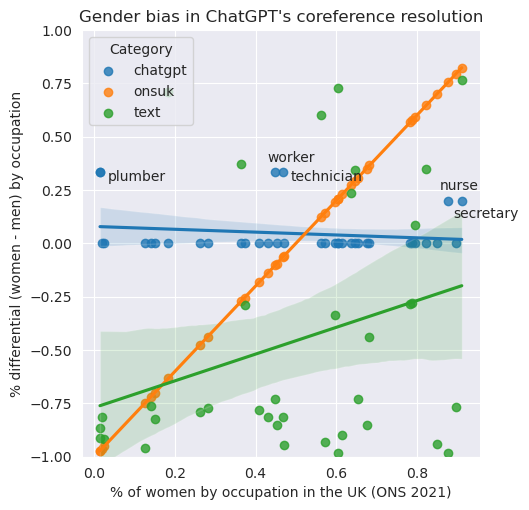

In [14]:
# edit the data frames for display


def get_bergsma_data():
    bergsma_data = []
    with open('occupations-stats.tsv') as csv_file:
        csv_data = csv.reader(csv_file, delimiter='\t')
        # row shape: ['occupation', 'bergsma_pct_female', 'bls_pct_female', 'bls_year']
        for row in csv_data:
            d = {}
            if row[0] in occupations:
                d['name'] = row[0] # occupation name
                d['f_percent_bergsma'] = float(row[1]) / 100
                # f + m = 100 => f - m = 100 - 2m = 100 - 2 (100 - f) = -100 + 2f
                # => f - m = 2f - 100
                d['fm_delta_bergsma'] = 2 * d['f_percent_bergsma'] - 1.00
                bergsma_data.append(d)
    return bergsma_data

bergsma_data_df = pd.DataFrame(get_bergsma_data())
bergsma_data_df = bergsma_data_df.astype({"name": str, "f_percent_bergsma": float})

# Plot chatgpt coreference resolution data vs uk employment data
occ_diffs_chatgpt_df = occ_df.loc[:, ["name", "fm_delta"]]
occ_diffs_onsuk_df = occ_df.loc[:, ["name", "fm_delta_uk"]]
occ_diffs_blsus_df = occ_df.loc[:, ["name", "fm_delta_us"]]
occ_diffs_bergsma_df = bergsma_data_df.loc[:, ["name", "fm_delta_bergsma"]]
# rename column so both dfs have the same column names (used to concatenate dfs)
occ_diffs_onsuk_df = occ_diffs_onsuk_df.rename(columns={"fm_delta_uk": "fm_delta"})
occ_diffs_blsus_df = occ_diffs_blsus_df.rename(columns={"fm_delta_us": "fm_delta"})
occ_diffs_bergsma_df = occ_diffs_bergsma_df.rename(columns={"fm_delta_bergsma": "fm_delta"})
# build lists to be used as category columns 
category_col_chatgpt = ['chatgpt'] * len(occ_df)
category_col_onsuk = ['onsuk'] * len(occ_df)
category_col_blsus = ['blsus'] * len(occ_df)
category_col_text = ['text'] * len(occ_df)
# first df: chatgpt data
occ_diffs_chatgpt_df["category"] = category_col_chatgpt 
occ_diffs_chatgpt_df["f_stats_uk"] = occ_df["f_percent_uk"] # stats_uk is used for the x axis
# second df: ons uk data
occ_diffs_onsuk_df["category"] = category_col_onsuk
occ_diffs_onsuk_df["f_stats_uk"] = occ_df["f_percent_uk"] # stats_uk is used for the x axis
# third df: text data (from bergsma)
occ_diffs_bergsma_df["category"] = category_col_text
occ_diffs_bergsma_df["f_stats_uk"] = occ_df["f_percent_uk"] # stats_uk is used for the x axis
# concatenate the three dfs
occ_diffs = pd.concat([occ_diffs_chatgpt_df, occ_diffs_onsuk_df, occ_diffs_bergsma_df],
                     ignore_index=True)


# alternative x axis with US data
# first df: chatgpt data
occ_diffs_chatgpt_df = occ_diffs_chatgpt_df.rename(columns={"f_stats_uk": "f_stats_us"})
occ_diffs_chatgpt_df["f_stats_us"] = occ_df["f_percent_us"] # stats_us is used for the x axis
# second df: bls us data
occ_diffs_blsus_df["category"] = category_col_blsus
occ_diffs_blsus_df["f_stats_us"] = occ_df["f_percent_us"] # stats_us is used for the x axis
# third df: text data (from bergsma)
occ_diffs_bergsma_df = occ_diffs_bergsma_df.rename(columns={"f_stats_uk": "f_stats_us"})
occ_diffs_bergsma_df["f_stats_us"] = occ_df["f_percent_us"] # stats_us is used for the x axis
# concatenate US data with the other two dfs
occ_diffs_us = pd.concat([occ_diffs_chatgpt_df, occ_diffs_blsus_df, occ_diffs_bergsma_df],
                     ignore_index=True)

sns.set_style('darkgrid')
plt = sns.lmplot(data=occ_diffs, x='f_stats_uk', y='fm_delta', hue='category', legend=False)
plt.set(xlabel='% of women by occupation in the UK (ONS 2021)', ylabel='% differential (women - men) by occupation')
plt.set(title="Gender bias in ChatGPT's coreference resolution")
plt.set(ylim=(-1.0, 1.0))
plt.axes[0,0].legend(loc='upper left', title='Category')

def label_point(x, y, val, ax):
    ax = ax.axes[0,0]
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        if point['val'] in ['plumber', 'worker', 'technician', 'nurse', 'secretary']:
            if point['val'] in ['worker', 'nurse']:
                ax.text(point['x']-.02, point['y']+.05, str(point['val']))
            elif point['val'] == 'secretary':
                ax.text(point['x']-.02, point['y']-.08, str(point['val']))
            else: # plumber
                ax.text(point['x']+.02, point['y']-.04, str(point['val']))

label_point(occ_df.f_percent_uk, occ_df.fm_delta, occ_df.name, plt)


#occ_diffs_blsus_df
#occ_diffs_us
#occ_diffs
#print(occ_diffs.to_string())
#bergsma_data_df

#occ_stats_df 
#occ_df
#occ_sorted

#print(occupations_info)

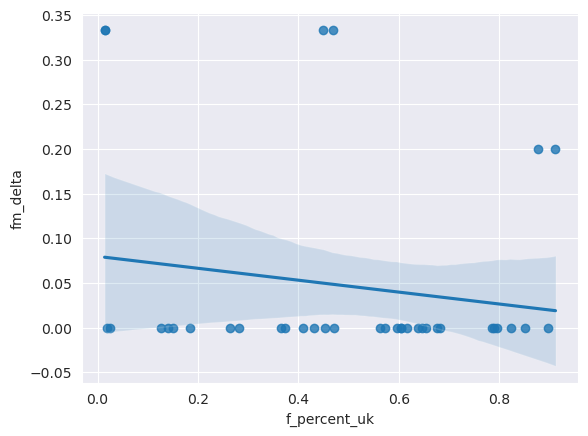

In [15]:

# alternative ploting of the ChatGPT data 
occ_df
sns.regplot(x="f_percent_uk", y="fm_delta", data=occ_df);

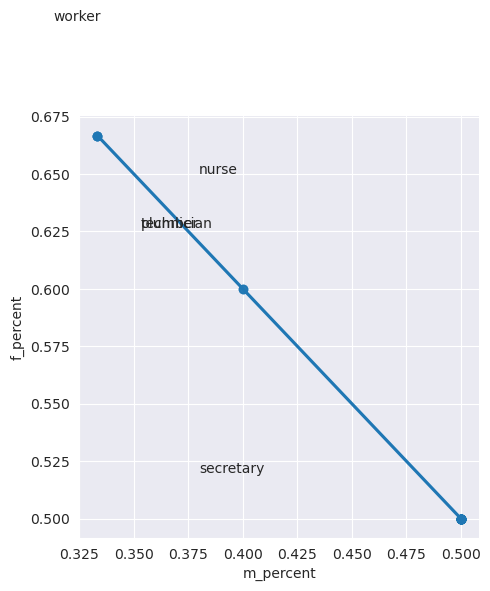

In [16]:

plt = sns.lmplot(data=occ_df, x='m_percent', y='f_percent')
label_point(occ_df.m_percent, occ_df.f_percent, occ_df.name, plt)

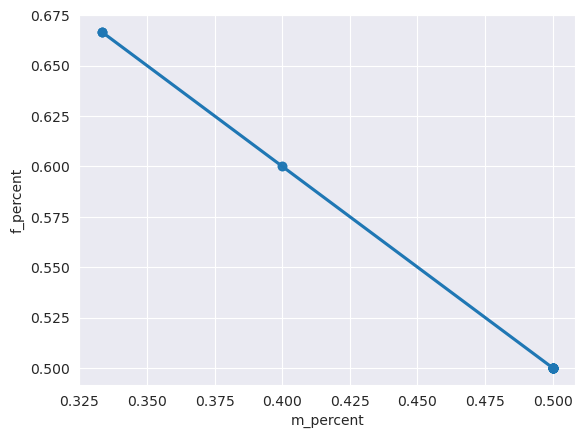

In [17]:
# yet another option for plotting of the ChatGPT data 
occ_df
sns.regplot(x="m_percent", y="f_percent", data=occ_df);
# for the interpretation, see below

,name,num,f_percent,m_percent,fm_delta,f_percent_uk,m_percent_uk,fm_delta_uk,f_percent_us,m_percent_us,fm_delta_us
0,technician,12,0.666667,0.333333,0.333333,0.467851,0.532149,-0.064299,0.032,0.968,-0.936
1,accountant,12,0.500000,0.500000,0.000000,0.430714,0.569286,-0.138573,0.597,0.403,0.194
2,supervisor,12,0.500000,0.500000,0.000000,0.789423,0.210577,0.578845,0.300,0.700,-0.400
3,engineer,12,0.500000,0.500000,0.000000,0.125551,0.874449,-0.748897,0.165,0.835,-0.670
4,worker,12,0.666667,0.333333,0.333333,0.448375,0.551625,-0.103251,0.500,0.500,0.000
5,nurse,12,0.600000,0.400000,0.200000,0.877327,0.122673,0.754653,0.874,0.126,0.748
6,dispatcher,12,0.500000,0.500000,0.000000,0.615602,0.384398,0.231203,0.508,0.492,0.016
7,cashier,12,0.500000,0.500000,0.000000,0.638095,0.361905,0.276190,0.731,0.269,0.462
8,auditor,12,0.500000,0.500000,0.000000,0.409563,0.590437,-0.180874,0.597,0.403,0.194
9,dietitian,12,0.500000,0.500000,0.000000,0.784593,0.215407,0.569187,0.914,0.086,0.828


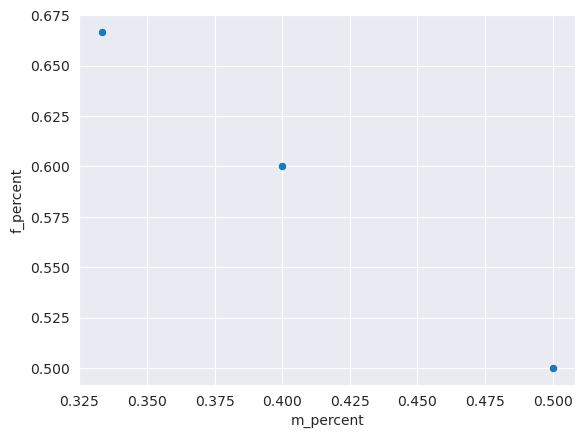

In [18]:
# most of the data points are at (0.5, 0.5) and there are a couple of outliers
# with a greater y-coordinate and lesser x-coordinate (these points also partially
# overalp, so can't be all distinguished in the graph)
sns.scatterplot(data=occ_df, x="m_percent", y="f_percent")
occ_df

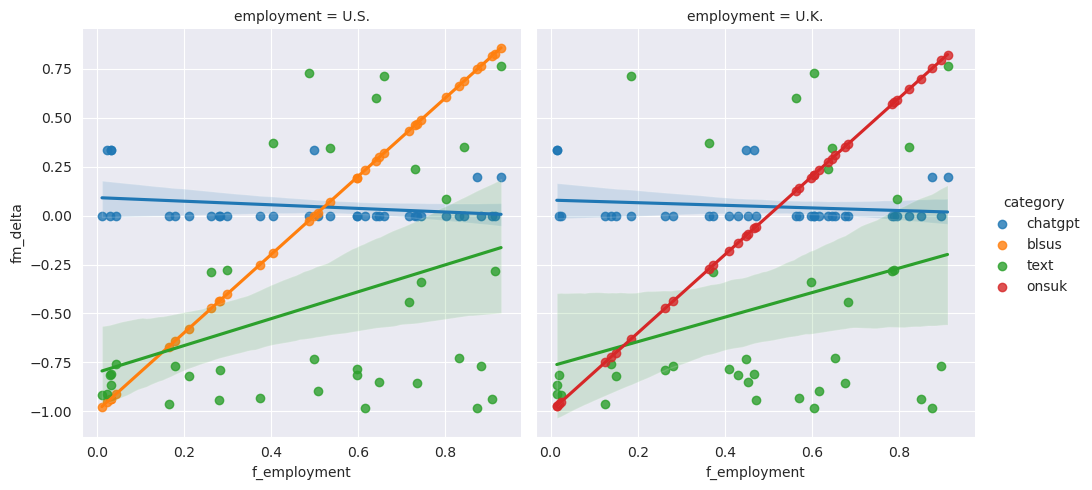

In [19]:
# an alternative presentation of the data
occ_diffs_ext_us = occ_diffs_us
occ_diffs_ext_uk = occ_diffs
occ_diffs_ext_us = occ_diffs_ext_us.rename(columns={"f_stats_us": "f_employment"})
occ_diffs_ext_uk = occ_diffs_ext_uk.rename(columns={"f_stats_uk": "f_employment"})
occ_diffs_ext_us['employment'] = ['U.S.'] * len(occ_diffs_ext_us)
occ_diffs_ext_uk['employment'] = ['U.K.'] * len(occ_diffs_ext_uk)
occ_diffs_ext = pd.concat([occ_diffs_ext_us, occ_diffs_ext_uk], ignore_index=True)
occ_diffs_ext
#sns.lmplot(x="total_bill", y="tip", hue="smoker", col="time", row="sex", data=tips, height=3);

# legend=False
sns.lmplot(data=occ_diffs_ext, x='f_employment', y='fm_delta', hue='category', col='employment')

In [20]:
import math
from scipy.stats import binomtest
from scipy.stats import chi2_contingency
from sklearn.linear_model import LinearRegression
from scipy import stats

f_counts = occ_df_nonnormalized.f_percent * occ_df_nonnormalized.num
m_counts = occ_df_nonnormalized.m_percent * occ_df_nonnormalized.num
n_counts = occ_df_nonnormalized.n_percent * occ_df_nonnormalized.num

fcount = int(f_counts.sum())
mcount = int(m_counts.sum())
ncount = int(n_counts.sum())
binomres = binomtest(k=fcount, n=fcount+mcount, p=0.5, alternative='greater')

# we first run a linear regression test and check that the regression coefficient
# is close enough to 1
print(f"Test 1 (x:m%, y:f%)\n------")
# Note: first arg to the linear regression (fit method) should be a 2D array (an array of arrays)
# reshape(-1,1) creates an array of the same length as the original array (that's what -1 means)
# and the second argument requires the sub-arrays to have dimension 1 (and contain the elements
# of the original array).
#x = occ_df["f_percent_uk"].to_numpy().reshape((-1, 1)) # official stats on x axis
#y = occ_df["fm_delta"].to_numpy()
x = occ_df["m_percent"].to_numpy().reshape((-1, 1)) # official stats on x axis
y = occ_df["f_percent"].to_numpy()
model = LinearRegression().fit(x, y)

# Note: an r-square approaching 1 says that x is correlated strongly with y,
# so that our linear model explains to a great extent variations of y via variations of x.
# The p-value, on the other hand, is a test of significance for the model, namely it tests
# the hypothesis that the slope of the model is 0. I p < significance level (0.05), the linear
# model fits the data and is significant.
# See: https://www.researchgate.net/post/What_is_the_relationship_between_R-squared_and_p-value_in_a_regression
# Also see: https://stats.stackexchange.com/questions/50425/what-is-the-relationship-between-r-squared-and-p-value-in-a-regression
# Also this: https://stats.stackexchange.com/questions/13314/is-r2-useful-or-dangerous?noredirect=1&lq=1
slope, intercept, r_value, p_value, std_err = stats.linregress(x.reshape(-1,),y)
print(f"slope: {slope}\n intercept: {intercept}\n p_value: {p_value}\n std_err: {std_err}\n R-squared: {r_value**2:.6f}")

#print(f"x: {x}")
#print(f"y: {y}")

r_sq = model.score(x, y)
print(f"coefficient of determination: {r_sq}")
print(f"intercept: {model.intercept_}")
print(f"slope: {model.coef_}")


print(f"Test 1.1 (x:stats, y: delta)\n-------------------------")

x = occ_df["f_percent_uk"].to_numpy().reshape((-1, 1)) # official stats on x axis
y = occ_df["fm_delta"].to_numpy()
model = LinearRegression().fit(x, y)


slope, intercept, r_value, p_value, std_err = stats.linregress(x.reshape(-1,),y)
print(f"slope: {slope}\n intercept: {intercept}\n p_value: {p_value}\n std_err: {std_err}\n R-squared: {r_value**2:.6f}")

r_sq = model.score(x, y)
print(f"coefficient of determination: {r_sq}")
print(f"intercept: {model.intercept_}")
print(f"slope: {model.coef_}")



print(f"Test 2\n------")
print(f"Setting: f# {fcount}, m# {mcount}, N = {fcount+mcount}")
print(f"Binomial test with H0: P(f) = 0.5 and H1: P(f) > 0.5")
print(f"where f = frequency of valid coreference resolutions of feminine-gendered pronouns {fcount}")
print(f"p-value: {binomres.pvalue}")
if binomres.pvalue < 0.05:
    print("We reject H0: P(f) = 0.5 in favour of H1: P(f) > 0.5 at the 5% level of significance.")
else:
    print("We accept H0: P(f) = 0.5 at the 5% level of significance.")
    

f_obs = occ_df.apply(lambda x: int(x["num"] * x["f_percent"]), axis=1).rename("f_obs")
m_obs = occ_df.apply(lambda x: int(x["num"] * x["m_percent"]), axis=1).rename("m_obs")
df_chi = f_obs.to_frame()
df_chi["m_obs"] = m_counts
fm_obs = df_chi[["f_obs", "m_obs"]].to_numpy()

chi_res = chi2_contingency(fm_obs)
pvalue = chi_res[1]
print(f"Chi-square test 3 (37 x 2)\n---------------------")
print(f"We assume H0: the variables f, m (the counts of feminine and masculine pronouns) are not correlated.")
print(f"The alternative hypothesis, H1 is that the variables are correlated.")
significance_level = 0.05
print(f"p value: {pvalue}") 
if pvalue <= significance_level:
    print('Reject the null hypothesis, H0, in favour of H1. So the variables are correlated.') 
else: 
    print('Accept the null hypothesis: there is no particular corellation between the variables, and any difference between them is due to chance.') 
    print('For our case, this means that we should not expect a bias towards one of these variables, since that would entail a significant difference between the variables.')

# include neuter gender data (use non-normalized table)
f_obs_1 = occ_df_nonnormalized.apply(lambda x: int(x["num"] * x["f_percent"]), axis=1).rename("f_obs")
m_obs_1 = occ_df_nonnormalized.apply(lambda x: int(x["num"] * x["m_percent"]), axis=1).rename("m_obs")
n_obs_1 = occ_df_nonnormalized.apply(lambda x: int(x["num"] * x["n_percent"]), axis=1).rename("n_obs")
df_chi_1 = f_obs.to_frame()
df_chi_1["m_obs"] = m_counts
df_chi_1["n_obs"] = n_counts
fmn_obs = df_chi_1.to_numpy()
    
chi_res = chi2_contingency(fmn_obs)
pvalue = chi_res[1]
print(f"Chi-square test 4 (37 x 3)\n------------------")
print(f"We assume H0: the variables f, m, n (the counts of feminine, masculine and neuter pronouns) are not correlated.")
print(f"The alternative hypothesis, H1 is that the variables are correlated.")
significance_level = 0.05
print(f"p value: {pvalue}") 
if pvalue <= significance_level:
    print('Reject the null hypothesis, H0, in favour of H1. So the variables are correlated.') 
else: 
    print('Accept the null hypothesis: there is no particular corellation between the variables, and any difference between them is due to chance.') 
    print('For our case, this means that we should not expect a bias towards one of these variables, since that would entail a significant difference between the variables.')
   
model

Test 1 (x:m%, y:f%)
------
slope: -0.9999999999999992
 intercept: 0.9999999999999996
 p_value: 3.462250163472298e-267
 std_err: 4.3626132888281325e-09
 R-squared: 1.000000
coefficient of determination: 1.0
intercept: 0.9999999999999998
slope: [-1.]
Test 1.1 (x:stats, y: delta)
-------------------------
slope: -0.06666707632422661
 intercept: 0.07966596778866505
 p_value: 0.3295493503420671
 std_err: 0.06742241001163811
 R-squared: 0.027176
coefficient of determination: 0.027175693968011116
intercept: 0.07966596778866508
slope: [-0.06666708]
Test 2
------
Setting: f# 113, m# 103, N = 216
Binomial test with H0: P(f) = 0.5 and H1: P(f) > 0.5
where f = frequency of valid coreference resolutions of feminine-gendered pronouns 113
p-value: 0.2701950543773501
We accept H0: P(f) = 0.5 at the 5% level of significance.
Chi-square test 3 (37 x 2)
---------------------
We assume H0: the variables f, m (the counts of feminine and masculine pronouns) are not correlated.
The alternative hypothesis, H1

LinearRegression()

In [21]:
# tests and summary of data (for code in the cell above)

def coref_summary():
    f_res = df.loc[(df['gender'] == 'f') & (df['score'] == 1)]
    m_res = df.loc[(df['gender'] == 'm') & (df['score'] == 1)]
    n_res = df.loc[(df['gender'] == 'n') & (df['score'] == 1)]
    f_res_0 = df.loc[(df['gender'] == 'f') & (df['score'] == 0)]
    m_res_0 = df.loc[(df['gender'] == 'm') & (df['score'] == 0)]
    n_res_0 = df.loc[(df['gender'] == 'n') & (df['score'] == 0)]
    zero_score = df.loc[df['score'] == 0]
    one_score = df.loc[df['score'] == 1]
    f_percentage_total = (len(f_res) + len(f_res_0)) / len(df) 
    f_percentage_valid = len(f_res) / len(df) 
    m_percentage_total = (len(m_res) + len(m_res_0)) / len(df) 
    m_percentage_valid = len(m_res) / len(df) 
    n_percentage_total = (len(n_res) + len(n_res_0)) / len(df) 
    n_percentage_valid = len(n_res) / len(df)
    print("COUNTS (SUMMARY)")
    print(f"F {len(f_res)} + M {len(m_res)} + N {len(n_res)} = {len(f_res) + len(m_res) + len(n_res)} (rows scored 1 per each gender)") 
    print(f"F {len(f_res_0)} + M {len(m_res_0)} + N {len(n_res_0)} = {len(f_res_0) + len(m_res_0) + len(n_res_0)} (rows scored 0 per each gender)") 
    print("PERCENTAGES (SUMMARY)")
    print(f"F {f_percentage_valid}, M {m_percentage_valid}, N {n_percentage_valid} (valid resolutions)")
    print(f"F {f_percentage_total}, M {m_percentage_total}, N {n_percentage_total} (all resolutions)")

def test_size():
    f_res = df.loc[(df['gender'] == 'f') & (df['score'] == 1)]
    m_res = df.loc[(df['gender'] == 'm') & (df['score'] == 1)]
    n_res = df.loc[(df['gender'] == 'n') & (df['score'] == 1)]
    zero_score = df.loc[df['score'] == 0]
    one_score = df.loc[df['score'] == 1]
    cond_1 = len(f_res) + len(m_res) + len(n_res) == len(one_score)
    cond_2 = len(f_res) + len(m_res) + len(n_res) + len(zero_score) == len(df)
    cond_3 = len(occupations) == len(occupation_stats.keys())
    if cond_1 and cond_2 and cond_3:
        # print(f"\033[32;1mData frame integrity OK.\033[0m")
        print(f"Data frame integrity OK.")
    else:
        print(f"\033[31;1mYou failed to parse some sentences in your data.\033[0m")
        print(f"{len(f_res) + len(m_res) + len(n_res)} (rows scored 1 actually processed).") 
        print(f"{len(zero_score)} (total rows scored 0)")
        print(f"{len(one_score)} (total rows scored 1)")
        print(f"{len(df)} (total rows in data frame)")
        #compute: df - f_res - m_res - n_res - zero_score
        fs = f_res['num'].tolist()
        ms = m_res['num'].tolist()
        ns = n_res['num'].tolist()
        zs = zero_score['num'].tolist()
        rest = set(df['num'].tolist()) - set(fs) - set(ms) - set(ns) - set(zs)
        rest = list(rest)
        rest.sort()
        print(f"Missing rows for sentences numbered:\n", rest)
        if len(occupations) > len(occupation_stats.keys()):
            diffs = set(occupations).difference(set(occupation_stats.keys()))
            print(f"Occupations {diffs} not in occupation_stats dictionary")
        elif len(occupation_stats.keys()) > len(occupations):
            diffs = set(occupation_stats.keys()).difference(set(occupations))
            print(f"Occupations {diffs} not in the occupations list.")


test_size()
coref_summary()

Data frame integrity OK.
COUNTS (SUMMARY)
F 113 + M 103 + N 109 = 325 (rows scored 1 per each gender)
F 36 + M 46 + N 39 = 121 (rows scored 0 per each gender)
PERCENTAGES (SUMMARY)
F 0.2533632286995516, M 0.23094170403587444, N 0.24439461883408073 (valid resolutions)
F 0.33408071748878926, M 0.33408071748878926, N 0.33183856502242154 (all resolutions)


# Observations

- the analysis is not about the validity of coreference resolution, but about biases in the coreference resoltion system (in ChatGPT). This analysis does not record errors in coreference resolution that occur with both grammatical genders.
- this analysis considers only (coreference resolution) errors that are due to the gender of pronouns and gender-association of noun phrases. They are due to gender and gender-associations because in the data gathering phase we vary only these gender features of the linguistic input.
- each data point, identified by the occupation that it targets (e.g. 'teacher') is balanced as to the gender of its pronouns, that is, it has an equal number of pronouns of each grammatical gender, e.g. "he" (masculine), "she" (feminine), "they" (neuter).
- the ChatGPT does not show any significant bias. One plausible explanation is that the outliers occur because of the 'attraction' and 'repulsion' of masculine pronouns relative to male-associated occupations and female-associated occupations respectively. Be that as it may, there are not enough outliers to bias the coreference resolution produced by the ChatGPT system.


,occupation,variable,value,gender
0,ceo,observed,11.0000,fem
1,ceo,expected,28.3647,masc
2,ceo,expected,10.6353,fem
3,ceo,observed,28.0000,masc
4,chef,expected,11.5497,fem
5,chef,expected,29.4503,masc
6,chef,observed,18.0000,fem
7,chef,observed,23.0000,masc
8,clerk,expected,22.6785,fem
9,clerk,expected,16.3215,masc


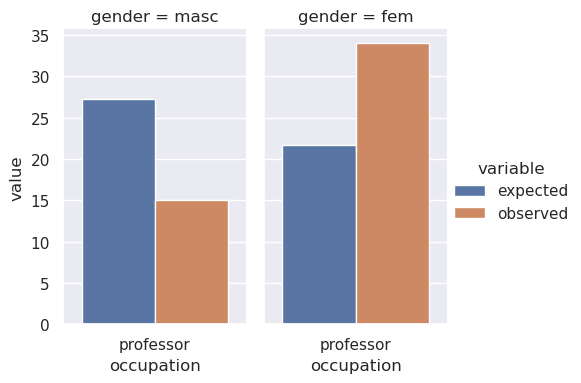

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

def get_story_data():
    story_data = []
    with open('stories-data.csv') as csv_file:
        csv_data = csv.reader(csv_file, delimiter=',')
        # row shape: "occupation", "f_gender", "m_gender", "total_count", "f_percent_uk"
        for row in csv_data:
            d = {}
            try:
                d['occupation'] = row[0] # occupation name
                d['f_gender'] = int(row[1])
                d['m_gender'] = int(row[2])
                # we don't use row[3] for the total count, as we want f% + g% = 100%
                # to be properly compared with emplyment stats (=> we ignore neuter pronouns)
                d['total_count'] = d['f_gender'] + d['m_gender']
                d['f_percent_uk'] = float(row[4])
                d['m_percent_uk'] = 1.0 - float(row[4])
                d['f_percent_observed'] = float(row[1]) / float(d['total_count'])
                d['m_percent_observed'] = float(row[2]) / float(d['total_count'])
                story_data.append(d)
            except ValueError:
                continue
    return story_data

story_data_df = pd.DataFrame(get_story_data())
# add column for expected women / men empolyed within each occupation
story_data_df['f_expect'] = story_data_df['total_count'] * story_data_df['f_percent_uk']
story_data_df['m_expect'] = story_data_df['total_count'] * story_data_df['m_percent_uk']
story_types = {"occupation": str, "f_gender": int, "m_gender": int, "total_count": int,
                "f_percent_uk": float, "m_percent_uk": float, "f_expect": float, "m_expect": float,
              "f_percent_observed": float, "m_percent_observed": float}
story_data_df = story_data_df.astype(story_types)


#story_data_df.describe()
story_data_df


# per occupation
sns.set()

# get cols: occupation, f_actual, m_gender, f_expect, m_expect
sfm_percent = story_data_df.iloc[:, [0,4,5,6,7]]
sfm_absolute = story_data_df.iloc[:, [0,1,2,8,9]]
sfm = sfm_absolute.rename(columns={"f_gender": "f_actual", "m_gender": "m_actual"})
sfm_percent = sfm_percent.rename(columns={"f_percent_uk": "f_expect", "m_percent_uk": "m_expect",
                                          "f_percent_observed": "f_actual", 
                                          "m_percent_observed": "m_actual"})

sf = sfm.iloc[:, [0,1,3]]  # occupation, f_actual, f_expect
sm = sfm.iloc[:, [0,2,4]]  # occupation, m_actual, m_expect
sf = sf.rename(columns={"f_actual":"observed", "f_expect":"expected"})
sm = sm.rename(columns={"m_actual":"observed", "m_expect":"expected"})
sf_melted = pd.melt(sf, id_vars = "occupation")
sm_melted = pd.melt(sm, id_vars = "occupation")

sf_melted['gender'] = ['fem'] * len(sf_melted)
sm_melted['gender'] = ['masc'] * len(sf_melted)
sfm_ext = pd.concat([sf_melted, sm_melted], ignore_index=True)
sfm_ext = sfm_ext.sort_values(by="occupation")
sfm_ext = sfm_ext.reset_index(drop=True)
#sns.barplot(data=sfm_ext[0:6], x='occupation', y='value', hue='variable', col='gender')

#fig, ax = plt.subplots(1, 2, sharey=True)
#sns.barplot(data=sf_melted[0:6], x="occupation", y="value", hue="variable", ax=axes[0])
#sns.barplot(data=sm_melted[0:6], x="occupation", y="value", hue="variable", ax=axes[1])

sns.catplot(
    data=sfm_ext[44:48], x="occupation", y="value", hue="variable", col="gender", #row="occupation",
    kind="bar", height=4, aspect=.6,
)

sfm_ext

[Text(0.5, 1.0, 'Professor'), Text(0.5, 19.049999999999997, '')]

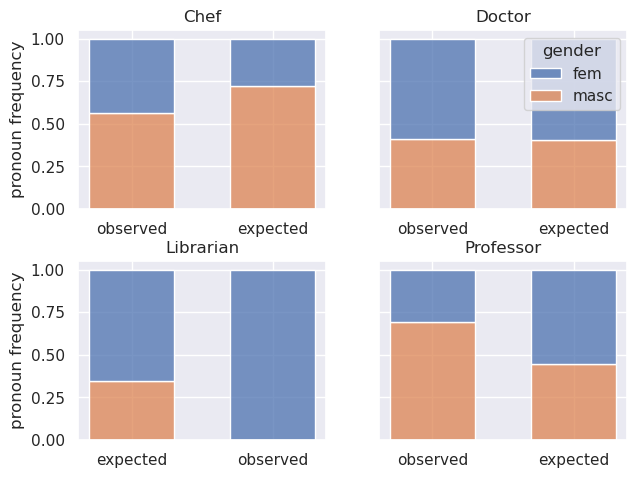

In [23]:
#sfm_percent

sf = sfm_percent.iloc[:, [0,1,3]]  # occupation, f_actual, f_expect
sm = sfm_percent.iloc[:, [0,2,4]]  # occupation, m_actual, m_expect
sf = sf.rename(columns={"f_actual":"observed", "f_expect":"expected"})
sm = sm.rename(columns={"m_actual":"observed", "m_expect":"expected"})

sf_melted = pd.melt(sf, id_vars = "occupation")
sm_melted = pd.melt(sm, id_vars = "occupation")

sf_melted['gender'] = ['fem'] * len(sf_melted)
sm_melted['gender'] = ['masc'] * len(sf_melted)
sfm_ext_percent = pd.concat([sf_melted, sm_melted], ignore_index=True)
sfm_ext_percent = sfm_ext_percent.sort_values(by="occupation")
sfm_ext_percent = sfm_ext_percent.reset_index(drop=True)


#import matplotlib.pyplot as plt
#import seaborn as sns

#set seaborn plotting aesthetics as default
sns.set()

#define plotting region (2 rows, 2 columns)
fig, axes = plt.subplots(2, 2, sharey=True)
fig.tight_layout()
#fig.suptitle('Gendered pronouns frequencies: observed vs expected')

sns.histplot(sfm_ext_percent[4:8], x='variable', hue='gender', weights='value',
             multiple='stack', shrink=0.6, legend=False, ax=axes[0,0]).set(title='Chef',
                                                                           xlabel=None,
                                                                          ylabel='pronoun frequency')

sns.histplot(sfm_ext_percent[12:16], x='variable', hue='gender', weights='value',
             multiple='stack', shrink=0.6, legend=True, ax=axes[0,1]).set(title='Doctor',xlabel=None)

sns.histplot(sfm_ext_percent[28:32], x='variable', hue='gender', weights='value',
             multiple='stack', shrink=0.6, legend=False, ax=axes[1,0]).set(title='Librarian',
                                                                           xlabel=None,
                                                                          ylabel='pronoun frequency')

sns.histplot(sfm_ext_percent[44:48], x='variable', hue='gender', weights='value',
             multiple='stack', shrink=0.6, legend=False, ax=axes[1,1]).set(title='Professor',xlabel=None)

#sfm_ext_percent

<AxesSubplot:xlabel='variable', ylabel='value'>

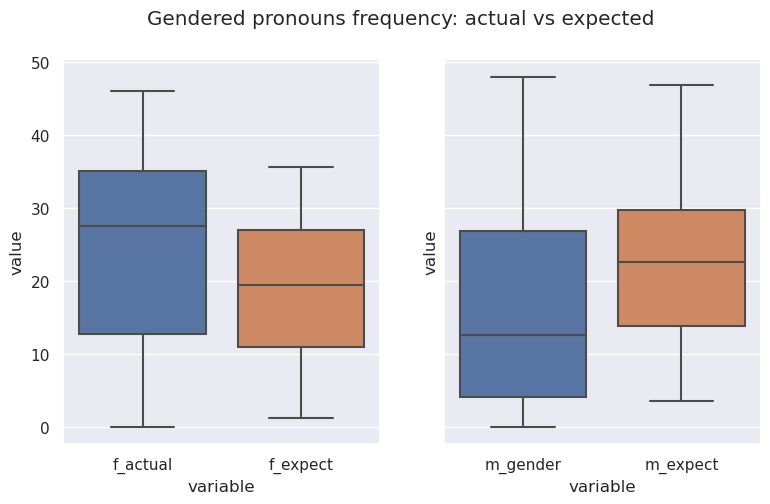

In [24]:
# overall
sns.set()
fig, axes = plt.subplots(1, 2, figsize=(9,5), sharey=True)
fig.suptitle("Gendered pronouns frequency: actual vs expected")
# select columns tracking the actual and expected frequence of gendered pronouns
subdf = story_data_df.iloc[:, [1,2,3,8,9]]
subdf = subdf.rename(columns={"f_gender": "f_actual"})
df_melted = pd.melt(subdf)
df_melted = df_melted.sort_values(by="variable")
df_melted = df_melted.reindex(range(len(df_melted)))
df_f = df_melted[df_melted['variable'].str.match(r'^f_')]
df_m = df_melted[df_melted['variable'].str.match(r'^m_')]
#df_f
df_melted[df_melted['variable'].str.match(r'^f_')]
sns.boxplot(x='variable', y='value', data=df_f, ax=axes[0])
sns.boxplot(x='variable', y='value', data=df_m, ax=axes[1])



In [25]:
from scipy.stats import binomtest

# significance test
story_count_total = subdf["total_count"].sum()
story_count_fem = subdf["f_actual"].sum()
story_count_fem_expected = subdf["f_expect"].sum()
story_percent_fem_expected = story_count_fem_expected / story_count_total
story_percent_fem_observed = story_count_fem / story_count_total
subdf.describe()
subdf

print("Setting\n--------")
print(f"Sample size: {story_count_total}")
print(f"f-pronouns number: {story_count_fem}")
print(f"expected P(f): {story_percent_fem_expected}")
print(f"observed P(f): {story_percent_fem_observed}")

print("Test 1\n------")
print(f"Binomial test 1 with H0: P(f) = 0.5 and H1: P(f) > 0.5")
print(f"where f = frequency of feminine-gendred pronouns, and the sample size {story_count_total}")
binomial_res_1 = binomtest(story_count_fem, n=story_count_total, p=0.5, alternative='greater')
if binomial_res_1.pvalue < 0.05:
    print(f"p-value: {binomial_res_1.pvalue}")
    print("We reject H0: P(f) = 0.5 in favour of H1: P(f) > 0.5 at the 5% level of significance.")
else:
    print("We accept H0: P(f) = 0.5")

print("Test 2\n------")
print(f"Binomial test 2 with H0: P(f) = {story_percent_fem_expected} and H1: P(f) > {story_percent_fem_expected}")
print(f"where f = frequency of feminine-gendred pronouns, and the sample size {story_count_total}")
binomial_res_2 = binomtest(story_count_fem, n=story_count_total, p=story_percent_fem_expected, alternative='greater')
if binomial_res_2.pvalue < 0.05:
    print(f"p-value: {binomial_res_2.pvalue}")
    print("We reject H0: P(f) = 0.5 in favour of H1: P(f) > 0.5 at the 5% level of significance")
else:
    print("We accept H0: P(f) = 0.5")


Setting
--------
Sample size: 575
f-pronouns number: 336
expected P(f): 0.45533234782608695
observed P(f): 0.5843478260869566
Test 1
------
Binomial test 1 with H0: P(f) = 0.5 and H1: P(f) > 0.5
where f = frequency of feminine-gendred pronouns, and the sample size 575
p-value: 3.0066914048144225e-05
We reject H0: P(f) = 0.5 in favour of H1: P(f) > 0.5 at the 5% level of significance.
Test 2
------
Binomial test 2 with H0: P(f) = 0.45533234782608695 and H1: P(f) > 0.45533234782608695
where f = frequency of feminine-gendred pronouns, and the sample size 575
p-value: 3.698468436623279e-10
We reject H0: P(f) = 0.5 in favour of H1: P(f) > 0.5 at the 5% level of significance


In [26]:
# a comparison of percentages
story_df_percent = story_data_df.loc[:, ['f_percent_uk', 'm_percent_uk', "f_percent_observed", "m_percent_observed"]]
rename_dict = {'f_percent_uk': 'f_expected', 'm_percent_uk':'m_expected', 
               "f_percent_observed":'f_observed', "m_percent_observed": 'm_observed'}
story_df_percent = story_df_percent.rename(columns=rename_dict)
story_df_percent.describe()
story_count = story_df_percent.describe().iloc[0,0]

#print(data['subjects'].loc[data.index[3]]) |(data['id'].iloc[0]) 
story_df_percent.describe()

,f_expected,m_expected,f_observed,m_observed
count,14.000000,14.000000,14.000000,14.000000
mean,0.469779,0.530221,0.597571,0.402429
std,0.285808,0.285808,0.354868,0.354868
min,0.024400,0.088200,0.000000,0.000000
25%,0.274950,0.360100,0.321295,0.102564
50%,0.461350,0.538650,0.726939,0.273061
75%,0.639900,0.725050,0.897436,0.678705
max,0.911800,0.975600,1.000000,1.000000


In [27]:
import os

# Convert jupyter notebook to pdf via pandoc

docname = "progen_bias"
bibfile = "references.bib"
citation_style = "acm.csl"

# pandoc command
pandoc_cmd = " ".join([f"pandoc -s {docname}.ipynb -t pdf -o {docname}.pdf",
              f"--lua-filter=parse_html.lua", # needed to parse HTML tables (in output cells)
              f"--citeproc", 
              f"--bibliography={bibfile}",
              f"--csl={citation_style}"])
os.system(pandoc_cmd)

# References


0